# Fairness plots and violin plots

### Importing

In [23]:
!pip install cvxpy

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import pickle

from approaches import baseline, cluster_methods, oracle
from approaches_ftc import ftc
from approaches_agenda import agenda

In [4]:
legend_fontsize = 14
title_fontsize = 18
label_fontsize = 16
ticks_fontsize = 14

In [5]:
db = pd.read_csv('data/rfw/rfw_w_sims.csv')
dataset_name = 'rfw'
feature = 'facenet'
calibration_method = 'beta'
nbins = 25
n_clusters = 100

In [10]:
display(db.head())

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id1,num1,id2,num2,ethnicity,pair,same,fold,facenet,facenet-webface,arcface
0,0,0,0,m.0g5ty_,1,m.0g5ty_,2,African,Genuine,True,0,0.733062,0.610138,NaN
1,1,1,1,m.05q5bqf,2,m.05q5bqf,3,African,Genuine,True,0,0.656041,0.536733,NaN
2,2,2,2,m.03yfnz5,2,m.03yfnz5,1,African,Genuine,True,0,0.624838,0.631015,NaN
3,3,3,3,m.03npynb,2,m.03npynb,3,African,Genuine,True,0,0.635635,0.593042,NaN
4,4,4,4,m.0h1f_hh,1,m.0h1f_hh,3,African,Genuine,True,0,0.788073,0.695494,NaN


In [6]:
subgroups = {'ethnicity': ['African', 'Asian', 'Caucasian', 'Indian']}
sensitive_attributes = {'ethnicity': ['ethnicity', 'ethnicity']}
fold = 5

In [7]:
features = ['facenet-webface']

In [8]:
title_features = {
    'facenet':'FaceNet (VGGFace2)',
    'facenet-webface':'FaceNet (Webface)',
    'arcface': 'ArcFace'}

In [9]:
title_methods = {
    'naive': 'Baseline',
    'fsn': 'FSN [36]',
    'faircal': 'Faircal (Ours)',
    'oracle': 'Oracle'
}

In [11]:
db_fold = {'cal': db[db['fold'] != fold], 'test': db[db['fold'] == fold]}

In [129]:
print(db_fold)

{'cal':        Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        id1  num1        id2  \
0                 0             0           0   m.0g5ty_     1   m.0g5ty_   
1                 1             1           1  m.05q5bqf     2  m.05q5bqf   
2                 2             2           2  m.03yfnz5     2  m.03yfnz5   
3                 3             3           3  m.03npynb     2  m.03npynb   
4                 4             4           4  m.0h1f_hh     1  m.0h1f_hh   
...             ...           ...         ...        ...   ...        ...   
23995         23995         23995       23995  m.0gb_yjt     2  m.05p6bss   
23996         23996         23996       23996   m.01qhc8     1  m.01wv0z3   
23997         23997         23997       23997   m.03w3mt     2  m.02qgh9z   
23998         23998         23998       23998   m.0674cw     4  m.09rv9x_   
23999         23999         23999       23999   m.03zd_s     2   m.070pyk   

       num2 ethnicity       pair   same  fold   facenet  facenet-we

### Getting dictionaries for cosine similarities (float), confidence scores (empty), ground truth labels (boolean) and subgroup scores (ethnicity)

In [95]:
scores = {}
confidences = {}
for feature in features:
    scores[feature] = {}
    confidences[feature] = {}
ground_truth = {}
subgroup_scores = {}
for dataset in ['cal', 'test']:
    for feature in features:
        scores[feature][dataset] = np.array(db_fold[dataset][feature])
    ground_truth[dataset] = np.array(db_fold[dataset]['same'])
    subgroup_scores[dataset] = {}
    for att in subgroups.keys():
        subgroup_scores[dataset][att] = {}
        subgroup_scores[dataset][att]['left'] = np.array(db_fold[dataset][sensitive_attributes[att][0]])
        subgroup_scores[dataset][att]['right'] = np.array(db_fold[dataset][sensitive_attributes[att][1]])

In [96]:
print(f'Cosine sims: {scores}\n')
print(f'Confidences: {confidences}\n')
print(f'Ground truth: {ground_truth}\n')
print(f'Subgroup scores: {subgroup_scores}\n')

Cosine sims: {'facenet-webface': {'cal': array([0.61013806, 0.536733  , 0.6310155 , ...,        nan,        nan,
              nan]), 'test': array([0.55725074, 0.6762695 , 0.5598125 , ..., 0.667508  , 0.7127251 ,
       0.41043848])}}

Confidences: {'facenet-webface': {}}

Ground truth: {'cal': array([ True,  True,  True, ..., False, False, False]), 'test': array([ True,  True,  True, ..., False, False, False])}

Subgroup scores: {'cal': {'ethnicity': {'left': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object), 'right': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object)}}, 'test': {'ethnicity': {'left': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object), 'right': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object)}}}



### Checking the size of the entries

In [97]:
print('Cosine similarity:', end = ' ')
print(len(scores[feature]['cal']), end = ' (cal), ')
print(len(scores[feature]['test']), end = ' (test)\n\n')

print('Ground truth:', end = ' ')
print(len(ground_truth['cal']), end = ' (cal), ')
print(len(ground_truth['test']), end = ' (test)\n\n')

print('Subgroup scores:', end = ' ')
print(len(subgroup_scores['cal']['ethnicity']['left']), end = ' (left), ')
print(len(subgroup_scores['cal']['ethnicity']['right']), end = ' (right)')

Cosine similarity: 21600 (cal), 2400 (test)

Ground truth: 21600 (cal), 2400 (test)

Subgroup scores: 21600 (left), 21600 (right)

### Drop missing values

In [98]:
indices = np.isnan(scores[feature]['cal']) == False
scores[feature]['cal'] = scores[feature]['cal'][np.logical_not(np.isnan(scores[feature]['cal']))]
ground_truth['cal'] = ground_truth['cal'][indices]
subgroup_scores['cal']['ethnicity']['left'] = subgroup_scores['cal']['ethnicity']['left'][indices]
subgroup_scores['cal']['ethnicity']['right'] = subgroup_scores['cal']['ethnicity']['right'][indices]

In [99]:
for feature in features:
    confidences[feature]['baseline'] = baseline(scores[feature], ground_truth, nbins, calibration_method)
    confidences[feature]['oracle'] = oracle(scores[feature], ground_truth, subgroup_scores, subgroups, nbins, calibration_method)

### Loading the embeddings

In [130]:
embedding_data = pickle.load(open(f'embeddings/{feature}_{dataset_name}_embeddings.pk', 'rb'))

if dataset_name == 'bfw':
    embedding_data['img_path'] = embedding_data['img_path'].apply(lambda x: x.replace('data/bfw/bfw-cropped-aligned/', ''))
if dataset_name == 'rfw':
    embedding_data['img_path'] = embedding_data['img_path'].apply(lambda x: x.replace('data/rfw/data/', ''))

In [131]:
print(embedding_data.head())

    category    person       image_id                              img_path  \
0  Caucasian  m.0cl9kh  m.0cl9kh_0001  Caucasian/m.0cl9kh/m.0cl9kh_0001.jpg   
1  Caucasian  m.0cl9kh  m.0cl9kh_0003  Caucasian/m.0cl9kh/m.0cl9kh_0003.jpg   
2  Caucasian  m.0cl9kh  m.0cl9kh_0004  Caucasian/m.0cl9kh/m.0cl9kh_0004.jpg   
3  Caucasian  m.0cl9kh  m.0cl9kh_0002  Caucasian/m.0cl9kh/m.0cl9kh_0002.jpg   
4  Caucasian  m.0cl9kh  m.0cl9kh_0005  Caucasian/m.0cl9kh/m.0cl9kh_0005.jpg   

                                           embedding  
0  [-0.07362084, -0.032686774, -0.023440572, -0.0...  
1  [-0.04244986, -0.001834187, -0.0017889304, -0....  
2  [-0.04558669, 0.016659236, -0.011350209, -0.00...  
3  [-0.076317206, 0.010774781, -0.03565117, -0.00...  
4  [-0.018754296, 0.0010367417, -0.0026780085, 0....  


In [132]:
print(feature)

facenet-webface


In [133]:
for feature in features:
    _, _, confidences[feature]['faircal'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                False,
                0,
                embedding_data
            )

kmeans took 473.70771884918213


FileNotFoundError: [Errno 2] No such file or directory: 'data/rfw/African_facenet-webface_embeddings.pickle'

In [ ]:
for feature in features:
    _, _, confidences[feature]['fsn'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                True,
                1e-3
            )

In [ ]:
for feature in features:
    _, confidences[feature]['ftc'], _ = ftc(dataset_name, feature, db_fold, nbins, calibration_method)

In [ ]:
for feature in features:
    _, confidences[feature]['agenda'], _, _, _ = agenda(dataset_name, feature, db_fold, nbins, calibration_method)

In [114]:
print(confidences['facenet-webface'].keys())

dict_keys(['baseline', 'oracle'])


In [115]:
db_fold['test']['baseline'] = confidences['facenet-webface']['baseline']['test']
db_fold['test']['oracle'] = confidences['facenet-webface']['oracle']['test']['ethnicity']
# db_fold['test']['fsn'] = confidences['facenet-webface']['fsn']['test']
# db_fold['test']['ftc'] = confidences['facenet-webface']['ftc']['test']
# db_fold['test']['agenda'] = confidences['facenet-webface']['agenda']['test']
# db_fold['test']['faircal'] = confidences['facenet-webface']['faircal']['test']

In [116]:
legend_fontsize = 18
title_fontsize = 24
label_fontsize = 20
ticks_fontsize = 18

In [127]:
db_fold['test']['pair'] = db_fold['test']['pair'].replace('Ungenuine', 'Imposter')

Baseline - African FPR = 1.667
Baseline - Asian FPR = 4.333
Baseline - Caucasian FPR = 2.667
Baseline - Indian FPR = 11.667


IndexError: list index out of range

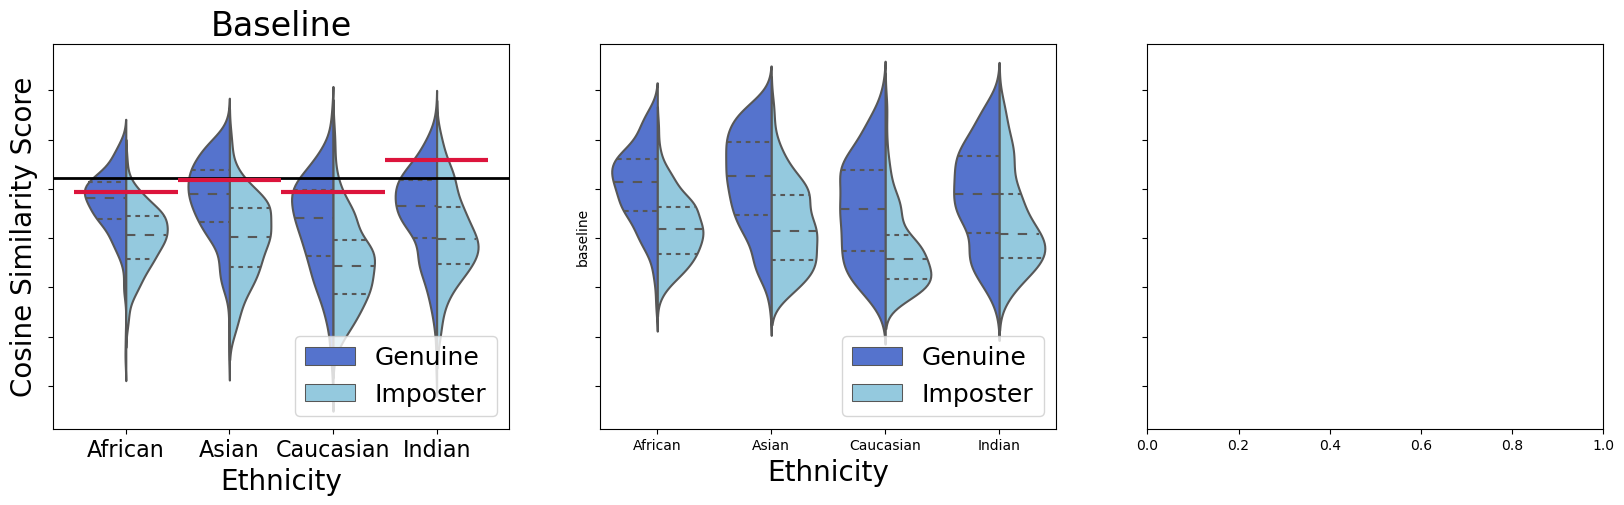

In [128]:
subgroups = ['African', 'Asian', 'Caucasian', 'Indian']
# title_columns = ['Baseline', 'Baseline+Calibration', 'Oracle Calibration', 'FairCal (Ours)']
title_columns = ['Baseline']
# columns = ['facenet-webface','baseline','oracle', 'bmc']
columns = ['facenet-webface','baseline','oracle']

fig, axes = plt.subplots(1,len(columns),figsize=(20,5), sharey=True)

# creating a dictionary with one specific color per group:
my_pal = {"Genuine": "royalblue", "Imposter": "skyblue"}
fpr_subgroup = {}
for i_aux, aux in enumerate(columns):
    sns.violinplot(
    x ='ethnicity',
    hue="pair",
    y=aux,
    split=True,
    data=db_fold['test'],
    scale="count",
    inner="quartile",
    ax = axes[i_aux],
    order=subgroups,
    palette=my_pal
)
    axes[i_aux].legend(loc = 'lower right', fontsize=legend_fontsize)
    axes[i_aux].set_xlabel('Ethnicity', fontsize=label_fontsize)
    axes[i_aux].set_title(title_columns[i_aux], fontsize=title_fontsize)
    if i_aux == 0:
        axes[i_aux].set_ylabel('Cosine Similarity Score', fontsize=label_fontsize)
    else:
        axes[i_aux].set_ylabel('Probability', fontsize=label_fontsize)
    labels = [item.get_text() for item in axes[i_aux].get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    axes[i_aux].set_yticklabels(empty_string_labels)

    axes[i_aux].tick_params(axis='x', labelsize=ticks_fontsize-2)

    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][aux],
            drop_intermediate=False,
            pos_label = True)
    
    axes[i_aux].axhline(global_thr[np.argmin(np.abs(global_fpr-0.05))],
                    ls='-',
                    linewidth=2,
                    alpha = 1,
                    c='black')
    fpr_subgroup[aux] = {}
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][aux][select],
            drop_intermediate=False,
            pos_label = True)
        axes[i_aux].hlines(y = thr[np.argmin(np.abs(fpr-0.05))],
                       ls='-',
                       color='crimson',
                       linewidth=3,
                       xmin =j-0.5,
                       xmax = j+1-0.5)
        fpr_subgroup[aux][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print("%s - %s FPR = %1.3f"%(title_columns[i_aux], subgroup, fpr_subgroup[aux][j]))
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_score_distributions_fpr_thresholds.png', bbox_inches='tight')

In [ ]:

feature = 'facenet-webface'
metrics = {'aad': {}, 'mad': {}, 'std': {}}
subgroups = ['African', 'Asian', 'Indian', 'Caucasian']
title_columns = ['Baseline', 'AGENDA','FTC', 'FSN', 'FairCal (Ours)']
columns = ['facenet-webface','agenda', 'ftc', 'fsn','bmc']
fig, axes = plt.subplots(1,len(columns),figsize=(20,5), sharey=True)
for i_aux,aux in enumerate(columns):
    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][aux],
            drop_intermediate=False,
            pos_label = True)
    fpr_subgroup[aux] = np.zeros(len(subgroups))
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][aux][select],
            drop_intermediate=False,
            pos_label = True)
        axes[i_aux].plot(np.interp(thr,global_thr[::-1],global_fpr[::-1]),fpr, linewidth=2)
        fpr_subgroup[aux][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print('%s %s - %1.1f'%(title_columns[i_aux],subgroup, fpr_subgroup[aux][j]))
    metrics['aad'][aux] = np.mean(np.abs(fpr_subgroup[aux]-np.mean(fpr_subgroup[aux])))
    metrics['mad'][aux] = np.max(np.abs(fpr_subgroup[aux]-np.mean(fpr_subgroup[aux])))
    metrics['std'][aux] = np.std(fpr_subgroup[aux])
    # print('AAD = %1.2f'%metrics['aad']['bmc'])
    # print('MAD = %1.2f'%metrics['mad']['bmc'])
    # print('STD = %1.2f'%metrics['std']['bmc'])
    axes[i_aux].plot([0.05, 0.05],[0,1],'--k',linewidth=2)
    axes[i_aux].legend(subgroups,loc = 'upper left')
    axes[i_aux].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
    axes[i_aux].set_xlim(0,0.1)
    axes[i_aux].set_ylim(0,0.18)
    axes[i_aux].set_title(title_columns[i_aux], fontsize=title_fontsize)
    axes[i_aux].set_xlabel('Global FPR', fontsize=title_fontsize)
    if i_aux == 0:
        axes[i_aux].set_ylabel('False Positive Rate', fontsize=title_fontsize)
    axes[i_aux].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_thr_vs_fpr.png', bbox_inches='tight')